<strong><b><font size="5">Modelos ARIMA - Como Determinar os Valores de p, d e q</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br

O que significam p, d e q no modelo ARIMA?

Um modelo ARIMA requer 3 parâmetros:

- param q: (int) Ordem do modelo MA.
- param p: (int) Ordem do modelo de AR.
- param d: (int) Número de vezes que os dados precisam ser diferenciados.

Nesta aula, vamos estudar como determinar o valor desses 3 parâmetros.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [2]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [3]:
# Pacote para calcular o número de diferenciações para tornar a série estacionária
#!pip install -q pmdarima

In [4]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import pmdarima
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10

## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Venture Capital (VC) é um tipo de fundo de investimento focado em capital de crescimento para empresas de médio porte que já possuem carteira de clientes e receita, mas que ainda precisam dar um salto de crescimento. 

VCs investem em empresas iniciantes, Startups e emergentes que foram consideradas com alto potencial de crescimento ou que demonstraram alto crescimento (em termos de número de funcionários, receita anual ou ambos).

A HappyMoonVC está analisando um novo e promissor negócio sugerido por uma Startup, o GoInRail.

O GoInRail é um método de transporte inovador que usa a tecnologia de propulsão a jato para executar um veículo similar a um Drone, mas sobre trilhos (que mantém o Drone carregado com energia elétrica) e transportar pessoas em alta velocidade!

O investimento só fará sentido se o GoInRail conseguir mais de 1 milhão de usuários mensais nos próximos 18 meses.

Nosso trabalho é analisar dados de séries temporais com a demanda de transporte em uma determinada região e prever a demanda pelo GoInRail, que ajude a HappyMoonVC a tomar sua decisão de investimento.

## Conjunto de Dados

Usaremos conjuntos de dados fictícios que mostram a demanda de clientes por transporte em uma determinada região. Para cada dia da semana, foi contabilizado quantas pessoas usaram o sistema de transporte na região. Os dados tem registros dos anos de 2017, 2018 e 2019.

São fornecidos 2 datasets:

- O primeiro possui 3 colunas, com id, data e total de clientes que usaram algum tipo de transporte. Será nossos dados de treino.

- O segundo possui 2 colunas, com id e data para os anos de 2019 e 2020. Será nosso dataset de teste.

In [5]:
# Carrega os dados
dados_treino = pd.read_csv("data/train.csv")
dados_teste = pd.read_csv("data/test.csv")

Vamos fazer algumas transformações nos dados para criar o modelo.

In [6]:
# Converte a coluna Datetime para o tipo correto
dados_treino['Datetime'] = pd.to_datetime(dados_treino.Datetime, format = '%d-%m-%Y %H:%M')

In [7]:
# Converte a coluna Datetime para o tipo correto
dados_teste['Datetime'] = pd.to_datetime(dados_teste.Datetime, format = '%d-%m-%Y %H:%M')

In [8]:
# Vamos extrair os detalhes da coluna Datetime: ano, mês, dia e hora
for i in (dados_treino, dados_teste):
    i['ano'] = i.Datetime.dt.year
    i['mes'] = i.Datetime.dt.month
    i['dia'] = i.Datetime.dt.day
    i['hora'] = i.Datetime.dt.hour

In [9]:
# Precisamos do dia da semana também
dados_treino['dia_semana'] = dados_treino['Datetime'].dt.dayofweek

In [10]:
# Seria bom verificar se o fato de ser final de semana ou não impacta no uso de transporte. 
# Vamos extrair essa informação. Dias da semana iguais a 5 ou 6 são sábado e domingo.

# Criamos uma função, onde marcamos final de semana como 1 e dias úteis como 0
def converteFimSemana(registro):
    if registro.dayofweek == 5 or registro.dayofweek == 6:
        return 1
    else:
        return 0

In [11]:
# Agora aplicamos a função
dados_treino['final_semana'] = dados_treino['Datetime'].apply(converteFimSemana)

In [12]:
# Vejamos como ficou o dataset
dados_treino.head()

,ID,Datetime,Count,ano,mes,dia,hora,dia_semana,final_semana
0,0,2017-08-25 00:00:00,8,2017,8,25,0,4,0
1,1,2017-08-25 01:00:00,2,2017,8,25,1,4,0
2,2,2017-08-25 02:00:00,6,2017,8,25,2,4,0
3,3,2017-08-25 03:00:00,2,2017,8,25,3,4,0
4,4,2017-08-25 04:00:00,2,2017,8,25,4,4,0


In [13]:
# Refinamos os dados para o gráfico da série original

# Definimos o índice do dataset
dados_treino.index = dados_treino['Datetime']

# Removemos a coluna ID, pois ela não é relevante neste caso
features = dados_treino.drop('ID',1)

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dados_treino['Count']

In [14]:
type(target)

pandas.core.series.Series

In [15]:
# Usaremos target como nossa série
target

Datetime
2017-08-25 00:00:00      8
2017-08-25 01:00:00      2
2017-08-25 02:00:00      6
2017-08-25 03:00:00      2
2017-08-25 04:00:00      2
                      ... 
2019-09-25 19:00:00    868
2019-09-25 20:00:00    732
2019-09-25 21:00:00    702
2019-09-25 22:00:00    580
2019-09-25 23:00:00    534
Name: Count, Length: 18288, dtype: int64

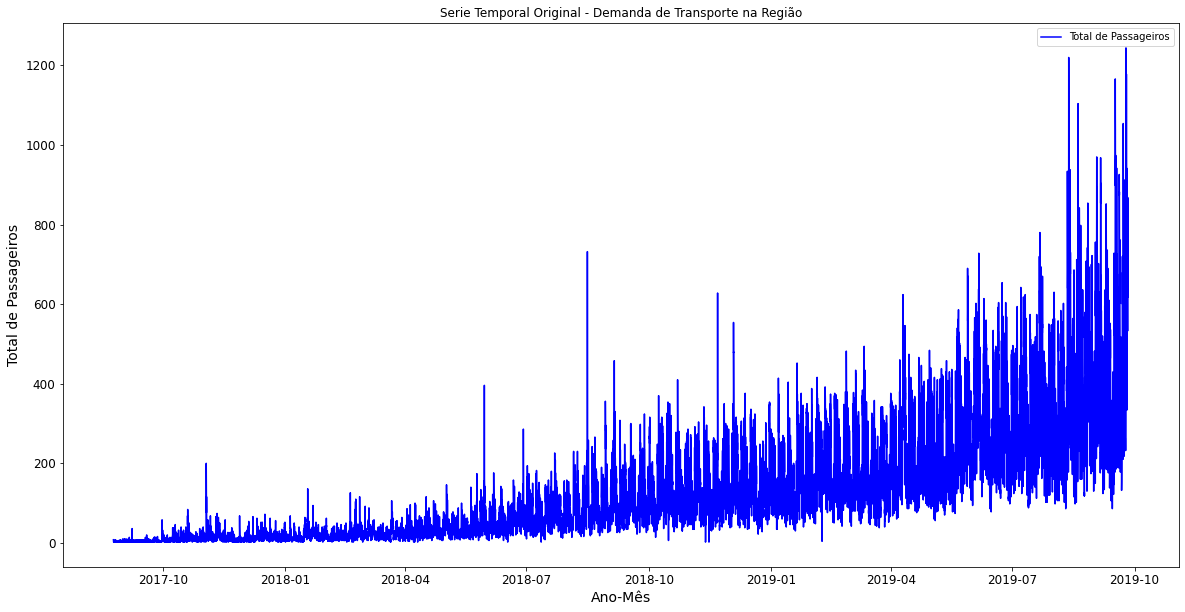

In [16]:
# Plot
plt.title("Serie Temporal Original - Demanda de Transporte na Região")
plt.plot(target, label = "Total de Passageiros", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Total de Passageiros")
plt.legend(loc = "best")

## Determinando o Valor do Parâmetro d para o Modelo ARIMA

O objetivo da diferenciação é tornar a série temporal estacionária.

Mas você precisa ter cuidado para não superestimar a série. Por isso, uma série super diferenciada ainda pode ser estacionária, o que, por sua vez, afetará os parâmetros do modelo.

Então, como determinar a ordem correta de diferenciação?

A ordem correta de diferenciação é a diferenciação mínima necessária para obter uma série quase estacionária que circula em torno de uma média definida e o gráfico ACF chega a zero rapidamente.

Se as autocorrelações forem positivas para muitos atrasos (10 ou mais), a série precisará ser diferenciada. Por outro lado, se a autocorrelação lag 1 em si for muito negativa, a série provavelmente será super diferenciada.

Se não for possível realmente decidir entre duas ordens de diferenciação, então escolha a ordem que apresenta o menor desvio padrão na série diferenciada.

Vamos ver como fazer isso com um exemplo.

Primeiro, vou verificar se a série é estacionária usando o teste Augmented Dickey Fuller (adfuller()), do pacote statsmodels ( que já usamos em várias aulas até aqui).

Por quê?

Porque você precisa diferenciar apenas se a série não for estacionária. Senão, nenhuma diferenciação é necessária, ou seja, d = 0.

A hipótese nula do teste ADF é que a série temporal não é estacionária. Portanto, se o valor-p do teste for menor que o nível de significância (0,05), você rejeitará a hipótese nula e poderá inferir que a série temporal é realmente estacionária.

Portanto, se o valor-p > 0,05, prosseguimos em busca da ordem da diferenciação. 

Vamos aplicar o Teste ADF mais uma vez em nossa série:

In [17]:
# Teste ADF
resultado = adfuller(dados_treino['Count'])
print('Estatística ADF: %f' % resultado[0])
print('Valor-p: %f' % resultado[1])

Estatística ADF: -4.456561
Valor-p: 0.000235


O valor-p é menor que 0.05, portanto, não precisamos calcular o valor de 'd'. Ou seja, d = 0 no Modelo ARIMA.

Entretanto, vamos fazer mais uma checagem. Vamos aplicar a diferenciação duas vezes a nossa série e comparar os gráficos ACF.

A função np.diff() aplica a diferenciação.

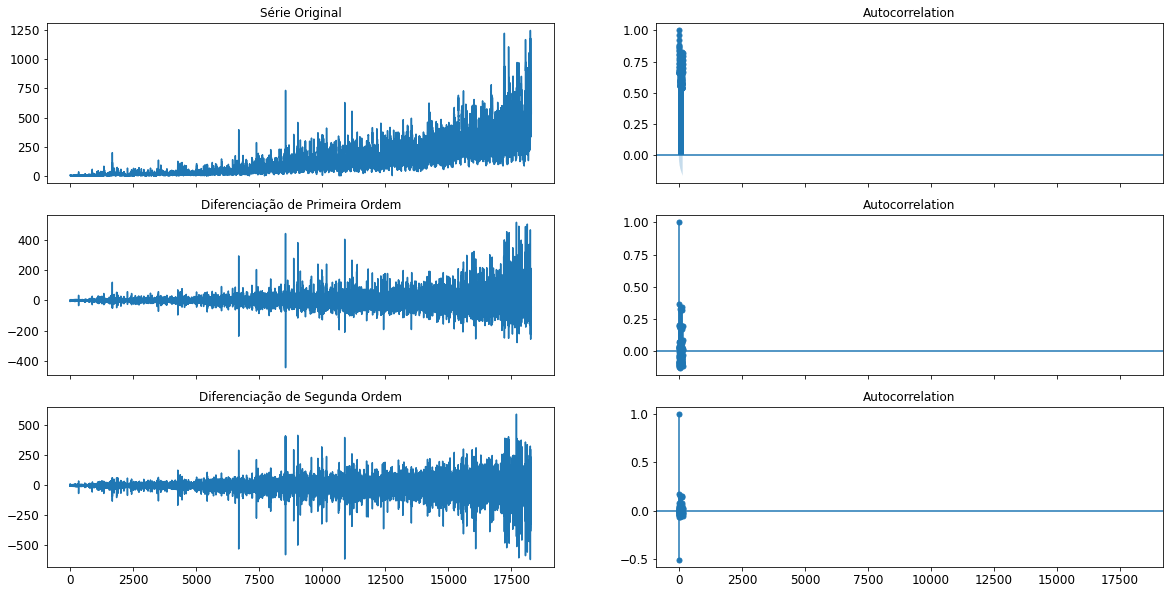

In [18]:
# Área de Plotagem
fig, axes = plt.subplots(3, 2, sharex = True)

# Série Original
axes[0, 0].plot(target.values); axes[0, 0].set_title('Série Original')
plot_acf(target.values, lags = 150, ax = axes[0, 1])

# Diferenciação de Primeira Ordem
axes[1, 0].plot(np.diff(target.values)); axes[1, 0].set_title('Diferenciação de Primeira Ordem')
plot_acf(np.diff(target.values), lags = 150, ax = axes[1, 1])

# Diferenciação de Segunda Ordem
axes[2, 0].plot(np.diff(np.diff(target.values))); axes[2, 0].set_title('Diferenciação de Segunda Ordem')
plot_acf(np.diff(np.diff(target.values)), lags = 150, ax = axes[2, 1])

plt.show()

Fica claro que a Diferenciação de Primeira Ordem distribuiu melhor a série. Ou seja, o valor d = 1 parece ser uma boa opção para o Modelo ARIMA.

Mas a Diferenciação de Primeira Ordem e Segunda Ordem estão bem parecidas. Por que não d = 2?

Afinal, a série temporal atinge a estacionariedade com duas ordens de diferenciação. Mas, olhando para o gráfico de autocorrelação para a segunda diferencial, o atraso (lag) entra na zona negativa distante (-0.5) razoavelmente rápido, o que indica que a série pode ter sido super diferenciada.

Portanto, a Diferenciação de Primeira Ordem parece ser mesmo a melhor opção, mesmo que a série não seja perfeitamente estacionária (fraca estacionariedade). Ou seja, d = 1. 

Mas espere, tenho mais um teste com a função ndiffs:

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html

Não fique bravo(a), mas tudo que foi feito acima poderia ser testado com o comando abaixo....hehehe. Mas eu tinha que fazer meu trabalho e explicar as coisas para você. :-)

In [19]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [20]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

Ou seja, o Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

Vamos escolher d = 1 pois vimos no gráfico a diferença quando aplicamos a primeira diferenciação. A escolha é sua meu caro(a) Cientista de Dados.

Já temos o I de ARIMA, o parâmetro d. Agora vamos encontrar o termo AR, com o parâmetro p.

## Determinando o Valor do Parâmetro p para o Modelo ARIMA

A próxima etapa é identificar se o modelo precisa de termos AR. Você pode descobrir o número necessário de termos AR, inspecionando o gráfico PACF (Partial Autocorrelation). Mas o que é PACF?

A autocorrelação parcial pode ser imaginada como a correlação entre a série e seu atraso, após excluir as contribuições dos atrasos intermediários. Portanto, o PACF meio que transmite a correlação pura entre um atraso e a série. Dessa forma, você saberá se esse atraso é necessário no termo AR ou não.

Qualquer autocorrelação em uma série estacionarizada pode ser retificada adicionando termos AR suficientes. Portanto, inicialmente consideramos a ordem do termo AR igual a tantas defasagens que ultrapassam o limite de significância no gráfico PACF.

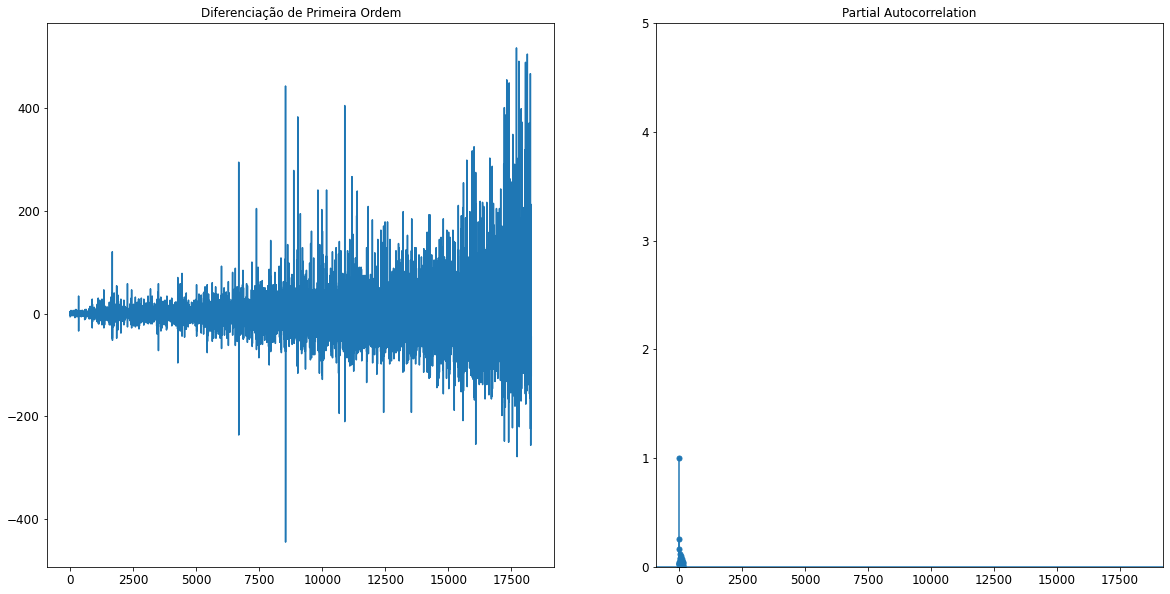

In [21]:
# Gráfico PACF
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,5))
plot_pacf(np.diff(target.values), lags = 150, ax = axes[1])
plt.show()

Humm... O gráfico PACF não está ajudando muito. Tudo bem, tenho mais uma ferramenta aqui na manga. Sabe como é. Quanto mais ferramentas você conhece, mais problemas você é capaz de resolver. Já dizia aquele instrutor da DSA.

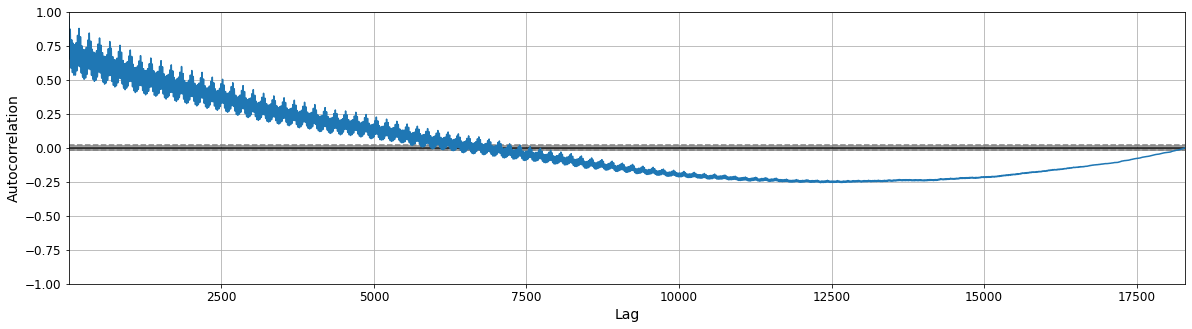

In [22]:
# Autocorrelation Plot
plt.figure(figsize = [20,5]) 
autocorrelation_plot(target)
plt.show()

Você pode observar que o atraso (lag) 1 é bastante significativo, pois está bem acima da linha de significância. O atraso 2 também é significativo, conseguindo ultrapassar o limite de significância. Mas vou ser conservador e definir o valor do parâmetro p igual a 1. Já temos o termo AR. Falta um. 

## Determinando o Valor do Parâmetro q para o Modelo ARIMA

Assim como observamos o gráfico PACF para o número de termos AR, você pode observar para o gráfico ACF para o número de termos MA. Um termo MA é tecnicamente o erro da previsão atrasada.

O ACF informa quantos termos MA são necessários para remover qualquer autocorrelação na série estacionarizada.

Vamos ver o gráfico de autocorrelação das séries diferenciadas.

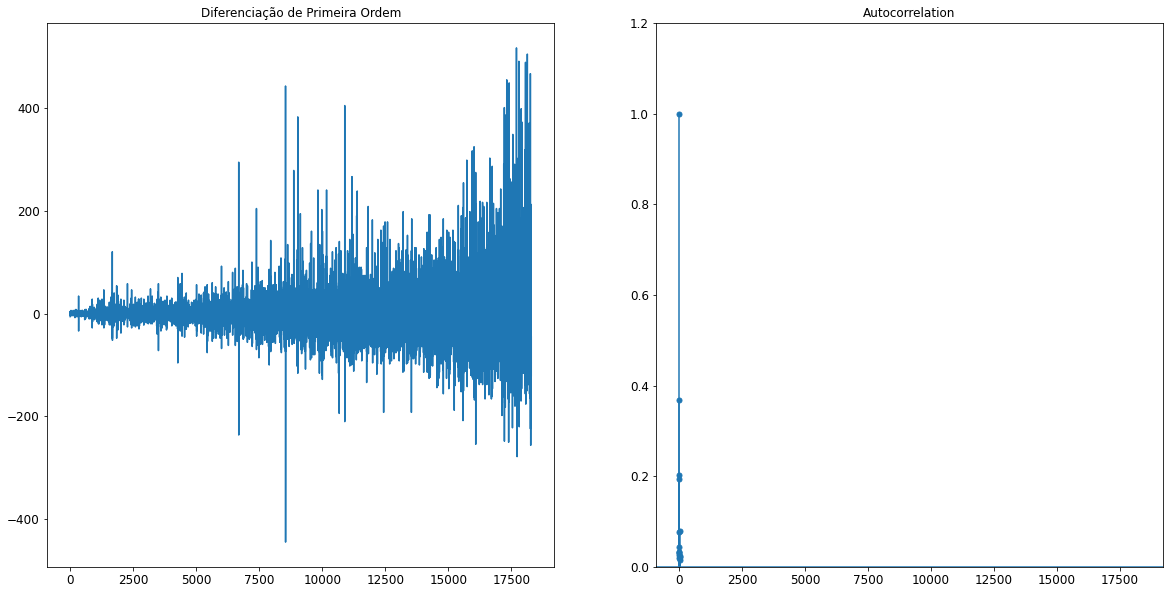

In [23]:
# Gráfico ACF
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,1.2))
plot_acf(np.diff(target.values), ax = axes[1])
plt.show()

O gráfico de autocorrelação indica que temos pelo menos um valor acima do limite de 0.2. Ou seja, q = 1 é o mínimo que deveríamos testar, embora o q = 2 seja uma opção. Você pode testar as duas opções se desejar, mas eu vou escolher q = 1.

Para quem gosta de regras, aqui está uma lista completa:

https://people.duke.edu/~rnau/arimrule.htm

Já temos os 3 parâmetros para o Modelo ARIMA (p, d, q) - order(1, 1, 1).

Mas espere. Nós tínhamos criado o Modelo ARIMA na Aula 13 com order (2, 1, 0). Ok, vamos alterar o modelo e ver o que acontece. 

Vamos preparar os dados para o modelo.

In [24]:
# Os dados de treino serão divididos em dados de treino e validação.
# Observe que os registros são separados em ordem cronológica.
df_treino = dados_treino.iloc[0:16057]
df_valid = dados_treino.iloc[16058:]

In [25]:
# Aplicando transformação de log
df_treino_log = np.log(df_treino['Count']) 

Agora aplicamos a diferenciação.

In [26]:
# Usando a função shift para mover a série em 1 e calcular a diferença.
df_treino_log_diff = df_treino_log - df_treino_log.shift(1) 

Vamos criar nosso Modelo ARIMA.

## Forecasting - Modelagem Preditiva Para Séries Temporais

### Modelo ARIMA

Vamos criar nosso primeiro Modelo ARIMA. Para começar vamos criar um modelo simples, treiná-los e fazer previsões e nas aulas seguintes vamos explorar os detalhes de Modelos ARIMA, como interpretar o resultado, os resíduos e melhorar o modelo.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [27]:
# Cria o Modelo ARIMA com order (1, 1, 1)
modelo_AR = ARIMA(df_treino_log, order = (1, 1, 1), freq = 'H')

In [28]:
# Treinamento
modelo_v1 = modelo_AR.fit(disp = -1)  

In [29]:
# Dados Reais e Previsões
dados_reais = df_treino_log_diff
previsoes = modelo_v1.fittedvalues

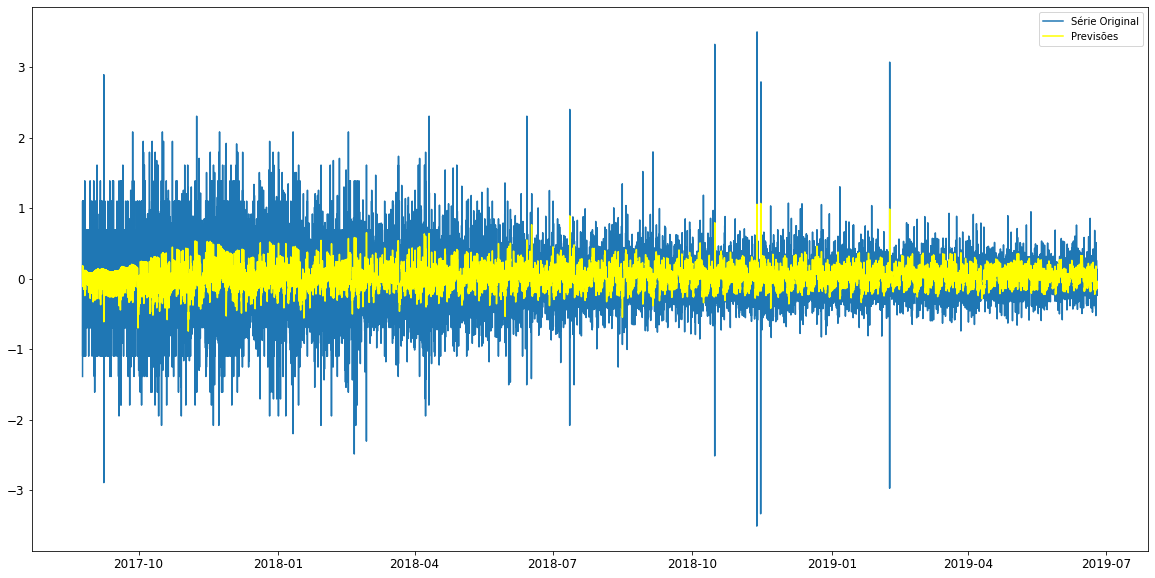

In [30]:
# Plot
plt.plot(dados_reais, label = 'Série Original') 
plt.plot(previsoes, color = 'yellow', label = 'Previsões') 
plt.legend(loc = 'best') 
plt.show()

Vamos fazer previsões com o modelo.

In [31]:
# Sumário do Modelo - Nas próximas aulas vamos interpretar esse sumário do modelo
modelo_v1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 15954.5847
Dependent Variable: D.Count          Log-Likelihood:      -7957.9   
Date:               2022-06-14 10:29 Scale:               1.0000    
No. Observations:   16056            Method:              css-mle   
Df Model:           3                Sample:              08-25-2017
Df Residuals:       16053                                 06-25-2019
Converged:          1.0000           S.D. of innovations: 0.397     
No. Iterations:     24.0000          HQIC:                15934.013 
AIC:                15923.8494                                      
---------------------------------------------------------------------
                Coef.   Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           0.0003    0.0001     2.8687  0.0041   0.0001   0.0005
ar.L1.D.Count   0.7365    0.0060   122.3936  0.0000   0.7247   0.7483
ma.L1.D.Count  -0.9915    0.0016  -602.6759  0.0000  -0.9947  -0.9883
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.3577             0.0000           1.3577             0.0000
MA.1            1.0086             0.0000           1.0086             0.0000
====================================================================

"""

Agora vamos fazer previsões com o modelo treinado.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html

In [32]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
df_valid_log = np.log(df_valid['Count'])

In [33]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(df_valid), alpha = 0.05) 

In [34]:
# Previsões
fc

array([5.78577929, 5.77160037, 5.76123423, ..., 6.3814424 , 6.38173453,
       6.38202667])

In [35]:
# Erro
se

array([0.39717721, 0.49528779, 0.54248619, ..., 0.85205988, 0.8521562 ,
       0.85225251])

In [36]:
# Coeficientes
conf

array([[5.00732627, 6.56423232],
       [4.80085414, 6.74234659],
       [4.69798085, 6.82448762],
       ...,
       [4.71143572, 8.05144907],
       [4.71153908, 8.05192999],
       [4.71164245, 8.05241089]])

In [37]:
# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = df_valid.index)
limite_inferior = pd.Series(conf[:, 0], index = df_valid.index)
limite_superior = pd.Series(conf[:, 1], index = df_valid.index)

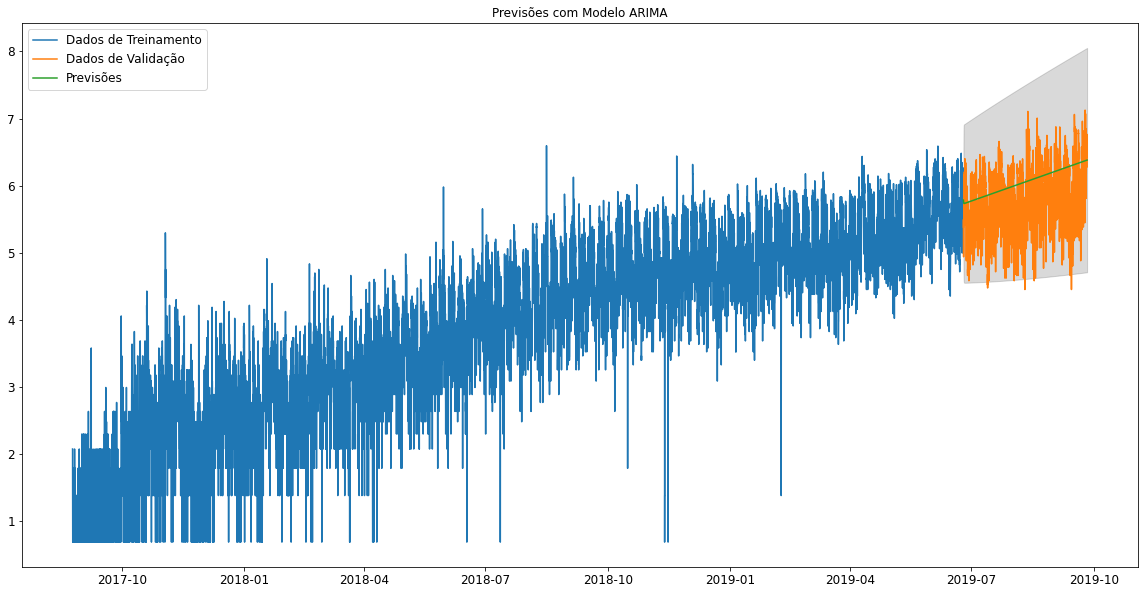

In [38]:
# Plot
plt.plot(df_treino_log, label = 'Dados de Treinamento')
plt.plot(df_valid_log, label = 'Dados de Validação')
plt.plot(fc_series, label = 'Previsões')
plt.fill_between(limite_inferior.index, limite_inferior, limite_superior, color = 'k', alpha = .15)
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [39]:
# Define valor real e valor previsto
y_true = df_valid_log
y_pred = fc_series

In [40]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

0.5246257895547219


Opa! Reduzimos ainda mais o erro do nosso modelo, apenas fazendo o estudo dos parâmetros ARIMA e escolhendo a melhor opção. Podemos usar até mesmo Cross Validation para isso. 

Continuamos na próxima aula.